# Setup

In [64]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [65]:
%matplotlib inline

In [66]:
from sparse_field_lib import load_data

In [67]:
import matplotlib.pyplot as plt
import sklearn
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [68]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import plotly.express as px
import plotly.graph_objects as go

In [69]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [70]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


In [71]:
# get average PSF and HLR
from hydra import initialize, compose
from omegaconf import OmegaConf
from bliss.datasets.galsim_galaxies import SDSSGalaxies
with initialize(config_path='../../config'):
    cfg = compose("config", overrides=['dataset=sdss_galaxies', 'model=galaxy_net'])
ds_kwargs = OmegaConf.to_container(cfg.dataset.kwargs, resolve=True)
ae_kwargs = OmegaConf.to_container(cfg)
ds = SDSSGalaxies(**ds_kwargs)
psf = ds.psf
print(psf.calculateHLR())

0.798554636726761


# Utility Functions

In [72]:
# precision and recall and matrix
from sklearn.metrics import confusion_matrix

def get_aggregate_metrics(keep_match, true_is_gal, pred_is_gal, true_n_total, n_unmatched=0):
    

    tp = sum(keep_match) # true positives = # of objects matched with a true object. 
    fp = sum(~keep_match) + n_unmatched # false positives = detected object not matched with true object.

    # precision 
    # recall = tp / total # of true objects
    precision = (tp / (tp + fp)).item()
    recall = (tp / true_n_total).item()
    f1 = (2 * precision * recall) / (precision + recall)
    
    # out off true matched objects.
    ratio_misclassed = sum(true_is_gal != pred_is_gal) / len(pred_is_gal)

    print(f'precision: {precision:.3f}')
    print(f'recall: {recall:.3f}')
    print(f'f1: {f1:.3f}')
    print(f'n_unmatched: {n_unmatched}')
    print(f'percentage misclassed: {ratio_misclassed*100:.2f}%')
    print()
    print(confusion_matrix(true_is_gal, pred_is_gal, labels=[True, False]))


In [73]:
def convert_mag_to_flux(mag, nelec_per_nmgy=987.31):
    # default corresponds to stripe 82 
    return 10**((22.5 - mag) / 2.5) * nelec_per_nmgy

def convert_flux_to_mag(flux, nelec_per_nmgy=987.31):
    return 22.5 - 2.5 * np.log10(flux / nelec_per_nmgy)

def get_flux_coadd(coadd_cat, nelec_per_nmgy=987.31):
    fluxes = []
    mags = []
    for i in range(len(coadd_cat)):
        is_star = bool(coadd_cat[i]['probpsf'])
        if is_star: 
            # star 
            psfmag = coadd_cat[i]['psfmag_r']
            flux = convert_mag_to_flux(psfmag, nelec_per_nmgy)
            mag = psfmag
        else: 
            # bulge+disk galaxy
            devmag = coadd_cat[i]['devmag_r']
            expmag = coadd_cat[i]['expmag_r']
            flux = convert_mag_to_flux(devmag, nelec_per_nmgy) + convert_mag_to_flux(expmag, nelec_per_nmgy)
            mag = convert_flux_to_mag(flux, nelec_per_nmgy)
            
        fluxes.append(flux)
        mags.append(mag)

    return np.array(fluxes), np.array(mags)  

import galsim
def get_hlr_coadd(coadd_cat, psf, psf_hlr=0.8, nelec_per_nmgy=987.31):
    if 'hlr' in coadd_cat.colnames: 
        return coadd_cat['hlr']
    
    hlrs = []
    for i in range(len(coadd_cat)):
        if i %100==0:
            print(i)
        
        entry  = coadd_cat[i]
        is_star = bool(entry['probpsf'])
        if is_star: 
            hlrs.append(psf_hlr)
        else: 
            components = []
            disk_flux = convert_mag_to_flux(entry["expmag_r"], nelec_per_nmgy)
            bulge_flux = convert_mag_to_flux(entry["devmag_r"], nelec_per_nmgy)

            if disk_flux > 0:
                disk_beta = np.radians(entry["expphi_r"])  # radians
                disk_hlr = entry["exprad_r"]  # arcsecs
                disk_q = entry["expab_r"]
                disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr).shear(
                    q=disk_q,
                    beta=disk_beta * galsim.radians,
                )
                components.append(disk)

            if bulge_flux > 0:
                bulge_beta = np.radians(entry["devphi_r"])
                bulge_hlr = entry["devrad_r"]
                bulge_q = entry["devab_r"]
                bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr).shear(
                    q=bulge_q,
                    beta=bulge_beta * galsim.radians,
                )
                components.append(bulge)
            gal = galsim.Add(components)
            gal = galsim.Convolution(gal, psf)
            try: 
                hlr = gal.calculateHLR()
            except: 
                hlr = np.nan
            hlrs.append(hlr)
    return np.array(hlrs)

# Load data

In [74]:
frame, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'].mean()
coadd_cat = Table(fits_file[:])
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))
frame = frame[0].numpy()
print(frame.shape)

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901
(1489, 2048)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [75]:
def get_data(coadd_cat):
    
    wcs = wcs_list[0]
    pt, pr = wcs.all_world2pix(coadd_cat['ra'], coadd_cat['dec'], 0)
    pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)
    is_star = coadd_cat['probpsf'].data.astype(bool)
    is_saturated = coadd_cat['is_saturated'].data.astype(bool)
    is_star_frame = frame_fits['PROB_PSF'][:, 2].data.astype(bool)

    # get fluxes and hlrs
    fluxes, mags = get_flux_coadd(coadd_cat)
    coadd_cat['flux'] = fluxes
    coadd_cat['mag'] = mags
    
    hlrs = get_hlr_coadd(coadd_cat, psf)
    coadd_cat['hlr'] = hlrs
    
    return pt, pr, pt_frame, pr_frame, is_star, is_star_frame, fluxes, mags, hlrs, is_saturated

In [76]:
pt, pr, pt_frame, pr_frame, is_star, is_star_frame, fluxes, mags, hlrs, is_saturated = get_data(coadd_cat)

0
100
200
300
400
500
600
700
800
900


In [77]:
# some useful keeps (not applied yet)
keep_coadd = (pt > 0) & (pt < frame.shape[1]-1) & (pr > 0) & (pr < frame.shape[0]-1) & (~is_saturated)
keep_frame = (pt_frame > 1) & (pt_frame < frame.shape[1]-1) & (pr_frame > 1) & (pr_frame < frame.shape[0]-1) & (frame_fits['PROB_PSF'][:, 2] > -1)
print(len(pt), len(pt_frame))

901 999


# Investigate Flux and Sizes

(array([347.,   3.,  15.,  27.,  19.,  31.,  44.,  29.,  19.,  20.,  17.,
         34.,  19.,  20.,  18.,  18.,  14.,  13.,   8.,  11.,   3.,   8.,
         10.,   6.,  10.,   7.,   2.,   7.,   6.,   9.,   5.,   7.,   5.,
          3.,   3.,   4.,   4.,   1.,   2.,   3.,   2.,   6.,   1.,   2.,
          2.,   2.,   0.,   1.,   1.,   1.]),
 array([0.8  , 0.844, 0.888, 0.932, 0.976, 1.02 , 1.064, 1.108, 1.152,
        1.196, 1.24 , 1.284, 1.328, 1.372, 1.416, 1.46 , 1.504, 1.548,
        1.592, 1.636, 1.68 , 1.724, 1.768, 1.812, 1.856, 1.9  , 1.944,
        1.988, 2.032, 2.076, 2.12 , 2.164, 2.208, 2.252, 2.296, 2.34 ,
        2.384, 2.428, 2.472, 2.516, 2.56 , 2.604, 2.648, 2.692, 2.736,
        2.78 , 2.824, 2.868, 2.912, 2.956, 3.   ]),
 [<matplotlib.patches.Polygon at 0x7f17dd1586d0>])

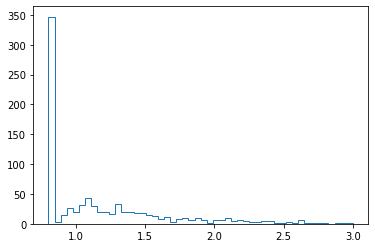

In [107]:
plt.hist(coadd_cat['hlr'], bins=50, histtype='step', range=(0.8, 3))

(array([  1.,   0.,   0.,   2.,   3.,   0.,   0.,   4.,   4.,   7.,  11.,
         13.,  12.,  18.,  20.,  32.,  40.,  43.,  40.,  76.,  96., 121.,
        113.,  95.,  77.,  37.,  25.,   5.,   3.,   3.]),
 array([12.30518543, 12.71232437, 13.11946331, 13.52660225, 13.93374119,
        14.34088014, 14.74801908, 15.15515802, 15.56229696, 15.9694359 ,
        16.37657484, 16.78371378, 17.19085272, 17.59799166, 18.00513061,
        18.41226955, 18.81940849, 19.22654743, 19.63368637, 20.04082531,
        20.44796425, 20.85510319, 21.26224214, 21.66938108, 22.07652002,
        22.48365896, 22.8907979 , 23.29793684, 23.70507578, 24.11221472,
        24.51935366]),
 [<matplotlib.patches.Polygon at 0x7f17dd1cac70>])

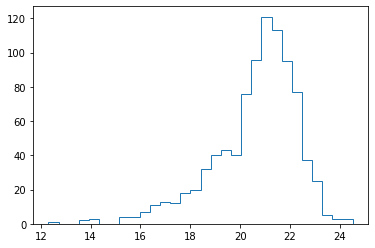

In [108]:
plt.hist(coadd_cat['mag'], bins=30, histtype='step')

In [109]:
# what cut on magnitude to use? 
convert_mag_to_flux(22) # total flux??? 

1564.780897848782

# Investigate Photo misclassifications on frame

In [110]:
# at what magnitudes/sizes does it start to go wrong?

In [111]:
from bliss.metrics import inner_join_locs
def photo_results(pt, pr, is_star, pt_frame, pr_frame, is_star_frame, mags, keep=None, keep_frame=None, max_mag=24.5):
    if keep is None:
        keep = np.ones(pt.shape).astype(bool)
    if keep_frame is None:
        keep_frame = np.ones(pt_frame.shape).astype(bool)
    
    pt,pr,is_star, mags = pt[keep], pr[keep], is_star[keep], mags[keep]
    pt_frame, pr_frame, is_star_frame = pt_frame[keep_frame], pr_frame[keep_frame], is_star_frame[keep_frame]

    plocs = torch.from_numpy(np.hstack((pt.reshape(-1, 1), pr.reshape(-1, 1))))
    plocs_frame = torch.from_numpy(np.hstack((pt_frame.reshape(-1, 1), pr_frame.reshape(-1, 1))))
    _plocs, _plocs_frame, row_indx, col_indx = inner_join_locs(plocs, plocs_frame)
    true_mags = mags[row_indx]

    # matched distances? 
    dist = (_plocs - _plocs_frame).abs().max(1)[0]
    dist_match = (dist < 1.).numpy().astype(bool)


    # aggreate metrics
    _is_galaxy = ~is_star[row_indx][dist_match]
    _is_galaxy_frame = ~is_star_frame[col_indx][dist_match]
    n_unmatched = max(0, len(plocs_frame) - len(plocs))
    get_aggregate_metrics(dist_match, _is_galaxy, _is_galaxy_frame, len(plocs), n_unmatched=n_unmatched)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    
    # create plot of num of matches as a function of magnitude, cutoff detection threshold when 
    # we need to bin detections by magnitudes
    mags = np.arange(15.0, max_mag, 0.25)
    n_matches_by_mag = np.array([sum(dist_match[true_mags > x])/len(dist_match[true_mags > x]) for x in mags])
    ax1.plot(mags, n_matches_by_mag, linestyle='-', marker='o', color='r')
    
    # create plot of num of matches as a function of magnitude, cutoff detection threshold when 
    # we need to bin detections by magnitudes
    mags = np.arange(15.0, max_mag, 0.25)
    n_matches_by_mag = np.array([sum(dist_match[(x < true_mags) & (x + 0.5 > true_mags)])\
                                 /len(dist_match[(x < true_mags) & (x + 0.5 > true_mags)]) for x in mags])
    ax2.plot(mags, n_matches_by_mag, linestyle='-', marker='o', color='r')

precision: 0.543
recall: 0.659
f1: 0.595
n_unmatched: 170
percentage misclassed: 16.67%

[[224  44]
 [ 43 211]]


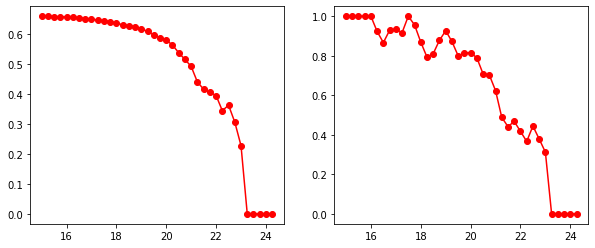

In [112]:
photo_results(pt, pr, is_star, pt_frame, pr_frame, is_star_frame, mags, max_mag=24.5, keep=keep_coadd, keep_frame=keep_frame)

precision: 0.541
recall: 0.675
f1: 0.600
n_unmatched: 192
percentage misclassed: 16.15%

[[226  45]
 [ 39 210]]


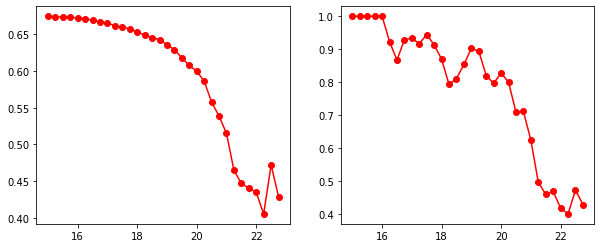

In [113]:
max_mag = 23
keep_mag = coadd_cat['mag'] < max_mag
photo_results(pt, pr, is_star, pt_frame, pr_frame, is_star_frame, mags, max_mag=max_mag, 
              keep=(keep_coadd&keep_mag), keep_frame=keep_frame)

# Prepare model

In [101]:
from bliss.models.binary import BinaryEncoder
from bliss.models.galaxy_encoder import GalaxyEncoder
from bliss.predict import prediction

In [102]:
# prepare BLISS model 
sleep_file = '/home/imendoza/bliss/models/sdss_sleep.ckpt'
galaxy_encoder_file = '/home/imendoza/bliss/models/sdss_galaxy_encoder.ckpt'
binary_file = '/home/imendoza/bliss/models/sdss_binary.ckpt'


# load models
image_encoder= sleep.SleepPhase.load_from_checkpoint(sleep_file).image_encoder.to(device).eval()
galaxy_encoder = GalaxyEncoder.load_from_checkpoint(galaxy_encoder_file).to(device).eval()
binary_encoder = BinaryEncoder.load_from_checkpoint(binary_file).to(device).eval()

## Filter Some objects

In [103]:
pt, pr, pt_frame, pr_frame, is_star, is_star_frame, fluxes, mags, hlrs, is_saturated = get_data(coadd_cat)

In [104]:
# remove all locations that are not inside the image. 
keep_mag = coadd_cat['mag'] < 23
keep = keep_coadd & keep_mag
pt = pt[keep]
pr = pr[keep]
is_star = is_star[keep]
mags = coadd_cat['mag'][keep]
hlrs = coadd_cat['hlr'][keep]

# Loop over chunks

In [105]:
import copy

h,w = frame.shape # full frame size.

cp = image_encoder.border_padding # chunk padding 
clen = 300 # chunk slen (square).
cplen = clen + cp*2 # padded chunk slen. 

ihic = h // clen # image height in chunks
iwic = w // clen # image width in chunks

locs = torch.tensor([])
galaxy_bool = torch.tensor([])
prob_galaxy = torch.tensor([])

pt1 = copy.deepcopy(pt)
pr1 = copy.deepcopy(pr)

keep = np.zeros((len(pt1))).astype(bool)

with torch.no_grad():
    for i in range(iwic):
        for j in range(ihic):
            print(i,j)
            x1,y1 = i*clen + cp, j*clen + cp
            pchunk = frame[y1 - cp: y1 + clen + cp, x1 - cp: x1 + clen + cp]
            assert pchunk.shape == (cplen, cplen)
            pchunk = pchunk.astype(np.float32)
            pchunk = torch.from_numpy(pchunk).to(device).reshape(1, 1, cplen, cplen)
            
            # get estimates with BLISS trained model. 
            _, tile_est, est_params = prediction(pchunk, image_encoder, binary_encoder=binary_encoder)
            
            _locs = est_params['locs'].cpu()
            _galaxy_bool = est_params['galaxy_bool'].cpu().reshape(-1, 1)
            _prob_galaxy = est_params['prob_galaxy'].cpu().reshape(-1)
            
            _locs = _locs.reshape(-1, 2)
            x, y = _locs[:, 1].reshape(-1, 1), _locs[:, 0].reshape(-1, 1)
            x = x*clen + x1 - 0.5 
            y = y*clen + y1 - 0.5 # pixels, same format as pt,pr
            locs1 = torch.hstack((x,y)).reshape(-1, 2).cpu()
            locs  = torch.cat((locs, locs1))
            
            _galaxy_bool = _galaxy_bool.reshape(-1, 1)
            galaxy_bool = torch.cat((galaxy_bool, _galaxy_bool))
            
            prob_galaxy = torch.cat((prob_galaxy, _prob_galaxy))
            
            # remove centroids from true photo in padding
            keep1 = (pt1 > x1) & (pt1 < x1+clen) & (pr1 > y1) & (pr1 < y1+clen)
            keep = keep | keep1

            # delete extra stuff in GPU and clear cache for next iteration.
            del pchunk
            del tile_est
            del est_params
            torch.cuda.empty_cache()

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3


In [106]:
mags1 = mags[keep]
pt1, pr1 = pt1[keep], pr1[keep]
is_star1 = is_star[keep]
hlrs1 = hlrs[keep]
locs = locs.numpy()
galaxy_bool = galaxy_bool.numpy()
prob_galaxy = prob_galaxy.numpy()

In [107]:
# how many objects are left? 
print(len(pt1), len(locs))

510 485


# Match objects

In [108]:
from bliss.metrics import inner_join_locs

_plocs = torch.from_numpy(np.hstack((pt1.reshape(-1, 1), pr1.reshape(-1, 1))))

_locs = torch.from_numpy(locs)
_galaxy_bool = torch.from_numpy(galaxy_bool)

# do matching
_plocs, _locs, row_indx, col_indx = inner_join_locs(_plocs, _locs)

#only keep match if l_{inf} < 1 pixel away
dist = (_plocs - _locs).abs().max(1)[0]
dist_match = (dist < 1.).numpy().astype(bool)

true_galaxy_bool = ~is_star1[row_indx].reshape(-1).astype(bool)
pred_galaxy_bool = _galaxy_bool[col_indx].reshape(-1).numpy().astype(bool)

_prob_galaxy = prob_galaxy[col_indx].reshape(-1)[dist_match]

true_mags = mags1[row_indx][dist_match].reshape(-1)
true_hlrs = hlrs1[row_indx][dist_match].reshape(-1)

In [109]:
# only check classification for objects that matched with a reasonable distance.
true_galaxy_bool = true_galaxy_bool[dist_match]
pred_galaxy_bool = pred_galaxy_bool[dist_match]
misclass = true_galaxy_bool != pred_galaxy_bool

# Results

In [110]:
n_unmatched = max(0, len(locs) - len(pt1))
get_aggregate_metrics(dist_match, true_galaxy_bool, pred_galaxy_bool, len(pt1), n_unmatched=n_unmatched)

precision: 0.678
recall: 0.645
f1: 0.661
n_unmatched: 0
percentage misclassed: 17.02%

[[111  46]
 [ 10 162]]


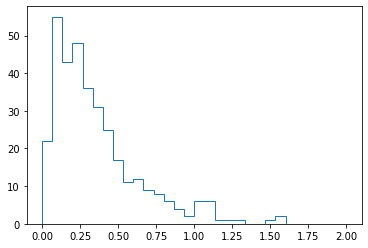

In [111]:
# histogram of mse between matching locations 
%matplotlib inline
plt.hist(dist.numpy(), bins=30, range=(0, 2.0), histtype='step');

ratio misclass with probability between 10%-90%: 0.321


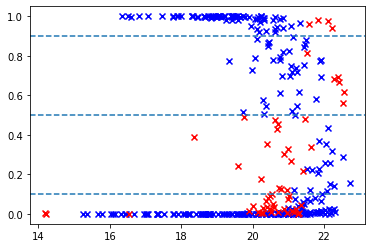

In [112]:
# scatter plot of miscclassification probs
probs_correct = _prob_galaxy[~misclass]
probs_misclass = _prob_galaxy[misclass]
plt.scatter(true_mags[~misclass], probs_correct, marker='x', c='b')
plt.scatter(true_mags[misclass], probs_misclass, marker='x', c='r')
plt.axhline(0.5, linestyle='--')
plt.axhline(0.1, linestyle='--')
plt.axhline(0.9, linestyle='--')

uncertain = (0.2 < _prob_galaxy[misclass]) & (_prob_galaxy[misclass] < 0.8)
r_uncertain = sum(uncertain) / len(_prob_galaxy[misclass])
print(f'ratio misclass with probability between 10%-90%: {r_uncertain:.3f}', )

ratio misclass with probability between 10%-90%: 0.321


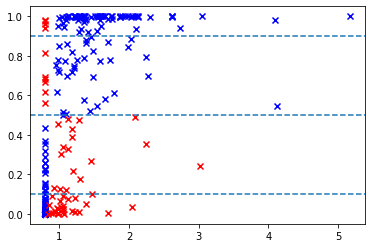

In [113]:
# scatter plot of miscclassification probs
plt.scatter(true_hlrs[~misclass], _prob_galaxy[~misclass], marker='x', c='b')
plt.scatter(true_hlrs[misclass], _prob_galaxy[misclass], marker='x', c='r')
plt.axhline(0.5, linestyle='--')
plt.axhline(0.1, linestyle='--')
plt.axhline(0.9, linestyle='--')

uncertain = (0.2 < _prob_galaxy[misclass]) & (_prob_galaxy[misclass] < 0.8)
r_uncertain = sum(uncertain) / len(_prob_galaxy[misclass])
print(f'ratio misclass with probability between 10%-90%: {r_uncertain:.3f}', )

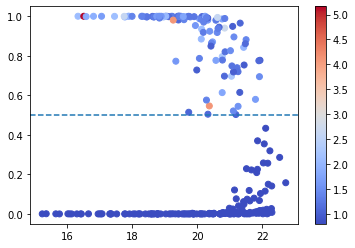

In [114]:
plt.scatter(true_mags[~misclass],_prob_galaxy[~misclass] , marker='o', c=true_hlrs[~misclass], cmap='coolwarm')
plt.axhline(0.5, linestyle='--')
plt.colorbar()

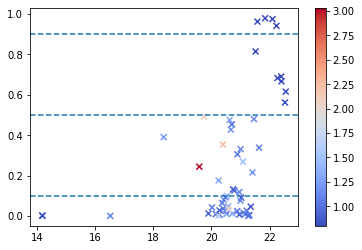

In [115]:
# scatter plot of miscclassification probst
# plt.scatter(true_mags[~misclass],_prob_galaxy[~misclass] , marker='o', c=true_hlrs[~misclass], cmap='coolwarm')
plt.scatter(true_mags[misclass], _prob_galaxy[misclass], marker='x', c=true_hlrs[misclass], cmap='coolwarm')
plt.axhline(0.5, linestyle='--')
plt.axhline(0.1, linestyle='--')
plt.axhline(0.9, linestyle='--')
plt.colorbar()